In [45]:
#Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Dropout

In [47]:
#Loading data from a CSV file
df = pd.read_csv('/content/drive/MyDrive/Datasets/apple_share_price.csv')

In [48]:
df.head()

,Date,Open,High,Low,Close,Volume
0,11-Aug-17,156.60,158.57,156.07,157.48,26257096
1,10-Aug-17,159.90,160.00,154.63,155.32,40804273
2,9-Aug-17,159.26,161.27,159.11,161.06,26131530
3,8-Aug-17,158.60,161.83,158.27,160.08,36205896
4,7-Aug-17,157.06,158.92,156.67,158.81,21870321


In [49]:
#Null
df.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Volume,0


In [50]:
#Duplicated
df.duplicated().sum()

0

In [51]:
#SHape
df.shape

(1664, 6)

df.reset_index(): This method is used to reset the index of a DataFrame. When you reset the index, the current index becomes a new column, and a default integer index is assigned to the DataFrame. This operation is often used to move the existing index (possibly a datetime index) to a regular column.

In [52]:
df1=df.reset_index()['Close']
df1

,Close
0,157.48
1,155.32
2,161.06
3,160.08
4,158.81
...,...
1659,48.02
1660,47.68
1661,47.71
1662,47.33


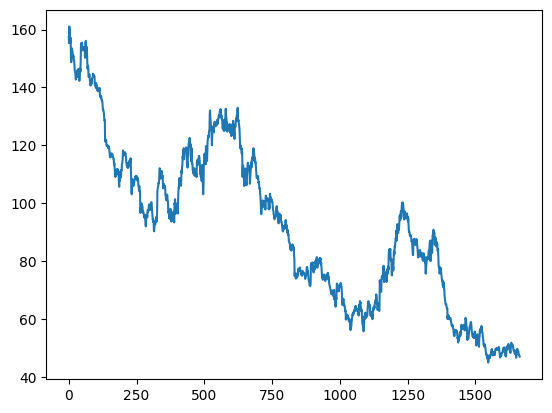

In [53]:
#Plotting
plt.plot(df1)

Normalize Data

Normalize the data to ensure that all features have the same scale. This is important for the LSTM to learn effectively.

In [56]:
scaler = MinMaxScaler(feature_range=(0, 1))
df['Close'] = scaler.fit_transform(np.array(df['Close']).reshape(-1, 1))
df

,Date,Open,High,Low,Close,Volume
0,11-Aug-17,156.60,158.57,156.07,0.969141,26257096
1,10-Aug-17,159.90,160.00,154.63,0.950522,40804273
2,9-Aug-17,159.26,161.27,159.11,1.000000,26131530
3,8-Aug-17,158.60,161.83,158.27,0.991552,36205896
4,7-Aug-17,157.06,158.92,156.67,0.980605,21870321
...,...,...,...,...,...,...
1659,7-Jan-11,47.71,48.05,47.41,0.025601,77982212
1660,6-Jan-11,47.82,47.89,47.56,0.022670,75106626
1661,5-Jan-11,47.08,47.76,47.07,0.022929,63879193
1662,4-Jan-11,47.49,47.50,46.88,0.019653,77337001


reshape(-1, 1): Reshapes the data into a 2D array with one column. This is necessary because MinMaxScaler expects a 2D array (e.g., [n_samples, n_features]).

Create Sequences for LSTM

Create input sequences for the LSTM model. This involves defining a window of past data that the model will use for prediction.

In [58]:
def create_sequences(data,seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        sequences.append(seq)
    return np.array(sequences)

seq_length = 10  # Adjust as needed
X = create_sequences(df['Close'], seq_length)
X

array([[0.96914059, 0.95052151, 1.        , ..., 0.96620981, 0.90509439,
        0.89371606],
       [0.95052151, 1.        , 0.99155245, ..., 0.90509439, 0.89371606,
        0.90035342],
       [1.        , 0.99155245, 0.98060512, ..., 0.89371606, 0.90035342,
        0.90949056],
       ...,
       [0.02137747, 0.02896302, 0.03111801, ..., 0.03335919, 0.02560124,
        0.02267046],
       [0.02896302, 0.03111801, 0.04077235, ..., 0.02560124, 0.02267046,
        0.02292906],
       [0.03111801, 0.04077235, 0.03732437, ..., 0.02267046, 0.02292906,
        0.01965348]])

Split Data into Training and Testing Sets

In [59]:
train_size = int(0.8 * len(X))
test_size = len(X) - train_size
train, test = X[0:train_size], X[train_size:len(X)]

Training Set (train):

X[0:train_size]: Slices the dataset X from index 0 to train_size - 1.
This includes the first 80% of the data.
Testing Set (test):

X[train_size:len(X)]: Slices the dataset X from index train_size to the end (len(X) - 1).
This includes the remaining 20% of the data.

In [65]:
from types import MethodWrapperType
#Model Building

model = Sequential()

# Add the first LSTM layer with return_sequences=True
model.add(LSTM(units=100, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))  # Add dropout for regularization

# Add a second LSTM layer with return_sequences=True
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))

# Add a third LSTM layer with return_sequences=True
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))

# Add a fourth LSTM layer without return_sequences (default is False)
model.add(LSTM(units=100))
model.add(Dropout(0.2))

# Add a Dense layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['accuracy'])

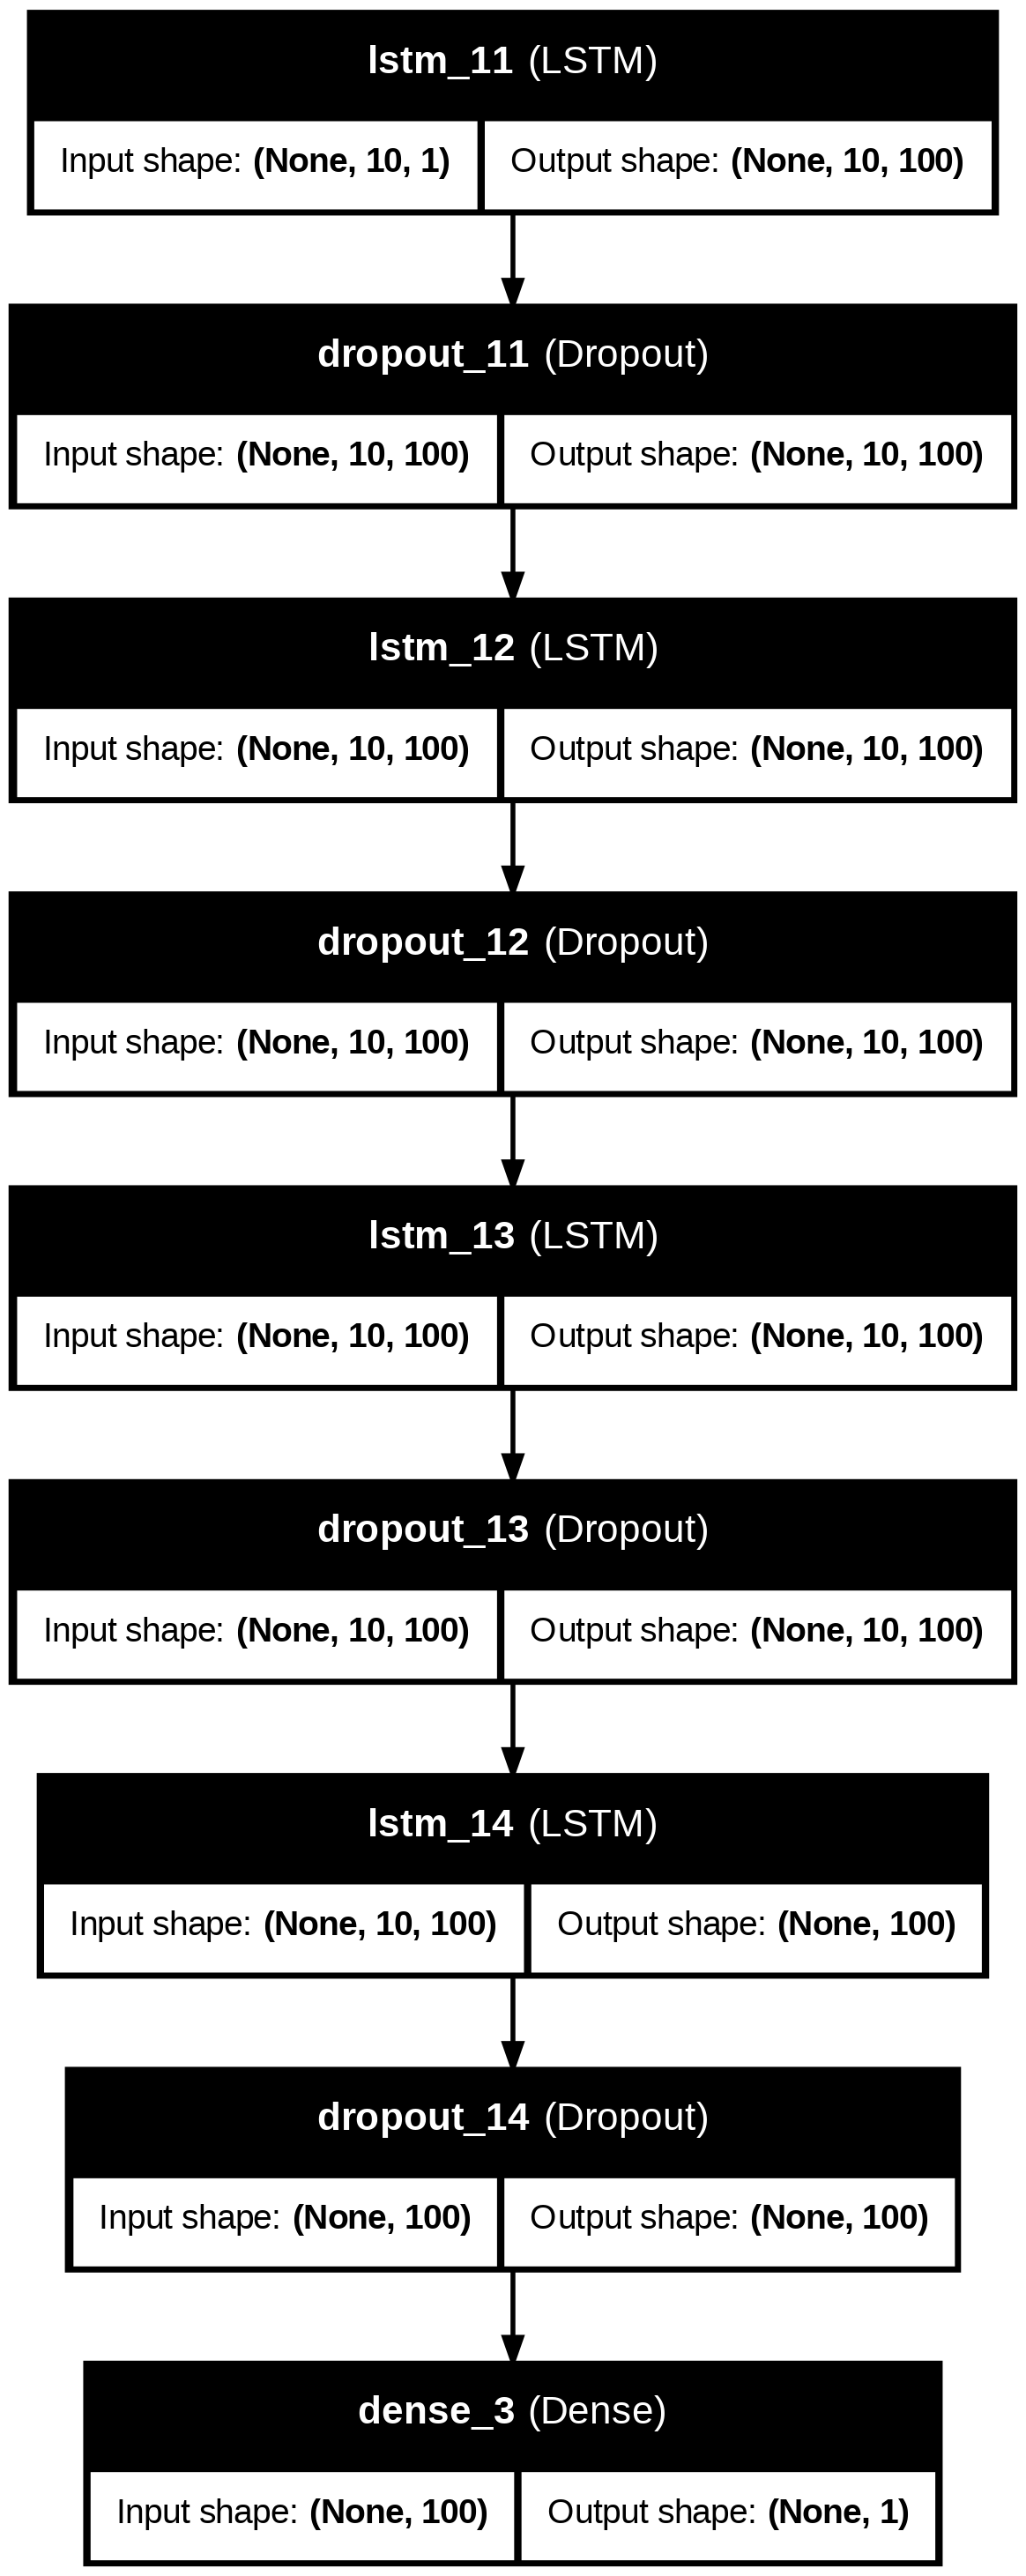

In [66]:
# LSTM Model Architecture
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [71]:
target_data = df['Close'][seq_length:seq_length+train_size]
history = model.fit(train, target_data, epochs=10, batch_size=32,validation_split=0.2)

Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.0000e+00 - loss: 0.0042 - val_accuracy: 0.0000e+00 - val_loss: 9.5478e-04
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.0000e+00 - loss: 0.0022 - val_accuracy: 0.0000e+00 - val_loss: 0.0024
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.0000e+00 - loss: 0.0030 - val_accuracy: 0.0000e+00 - val_loss: 9.5260e-04
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.0000e+00 - loss: 0.0023 - val_accuracy: 0.0000e+00 - val_loss: 0.0012
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.0000e+00 - loss: 0.0025 - val_accuracy: 0.0000e+00 - val_loss: 0.0014
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.0000e+00 - loss: 0.0018 - val_accuracy: 0.0000e+00 - val_loss: 9.3930e-04
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.0000e+00 - loss: 0.0018 - val_accuracy: 0.0000e+00 - val_loss: 8.5291e-04
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 2

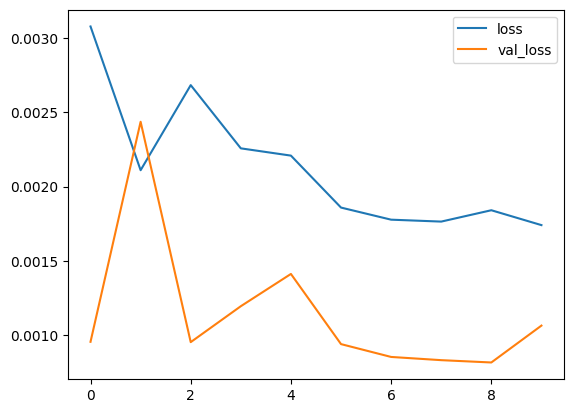

In [72]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();

When to Use Which?

Use .iloc when:

The index is not meaningful (e.g., default integer index).
You're working with positional indexing.

Use .loc when:

The index is meaningful (e.g., dates, IDs).
You want to access data using labels.

In [73]:
# Make Predictions
predictions = model.predict(test)
predictions = scaler.inverse_transform(predictions)

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step


Plot Results

<ipython-input-74-a9240dfe677f>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



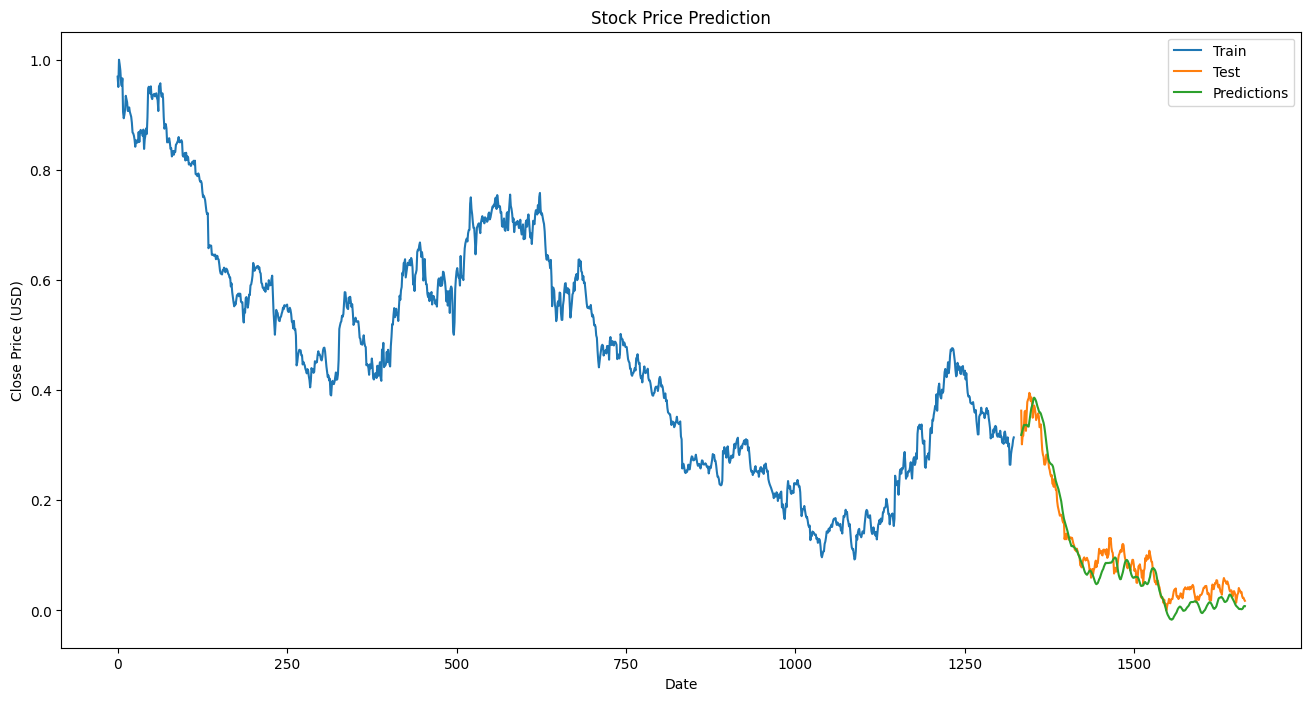

In [74]:
train = df.iloc[:train_size]
test = df.iloc[train_size+seq_length:, :]

test['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.plot(train['Close'])
plt.plot(test[['Close', 'Predictions']])
plt.legend(['Train', 'Test', 'Predictions'])
plt.show()

In [81]:
train

,Date,Open,High,Low,Close,Volume
0,11-Aug-17,156.60,158.57,156.07,0.969141,26257096
1,10-Aug-17,159.90,160.00,154.63,0.950522,40804273
2,9-Aug-17,159.26,161.27,159.11,1.000000,26131530
3,8-Aug-17,158.60,161.83,158.27,0.991552,36205896
4,7-Aug-17,157.06,158.92,156.67,0.980605,21870321
...,...,...,...,...,...,...
1318,16-May-12,79.15,79.56,77.29,0.284113,140223874
1319,15-May-12,80.21,80.46,78.82,0.292820,119076678
1320,14-May-12,80.37,81.07,79.66,0.299112,88156103
1321,11-May-12,80.71,82.07,80.62,0.309542,99886332


In [82]:
test

,Date,Open,High,Low,Close,Volume,Predictions
1333,25-Apr-12,87.95,88.29,86.57,0.362814,226427670,0.318749
1334,24-Apr-12,80.37,81.10,79.29,0.301612,269099838,0.323352
1335,23-Apr-12,81.52,82.38,79.52,0.315662,241629479,0.328378
1336,20-Apr-12,84.48,84.95,81.49,0.317214,257743808,0.332677
1337,19-Apr-12,85.75,86.39,83.50,0.335057,208678365,0.336585
...,...,...,...,...,...,...,...
1659,7-Jan-11,47.71,48.05,47.41,0.025601,77982212,0.002652
1660,6-Jan-11,47.82,47.89,47.56,0.022670,75106626,0.003890
1661,5-Jan-11,47.08,47.76,47.07,0.022929,63879193,0.006754
1662,4-Jan-11,47.49,47.50,46.88,0.019653,77337001,0.008078


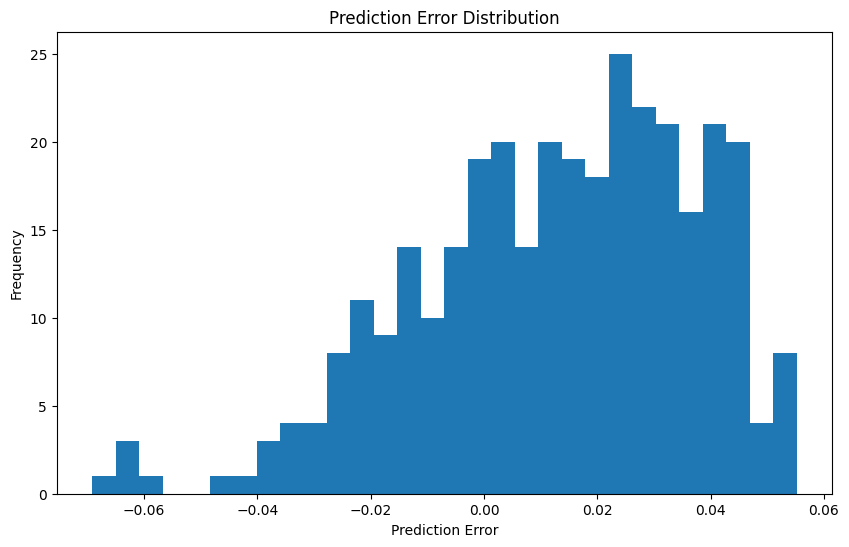

In [75]:
#Prediction Error Distribution
error = test['Close'] - test['Predictions']
plt.figure(figsize=(10,6))
plt.hist(error, bins=30)
plt.title('Prediction Error Distribution')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()

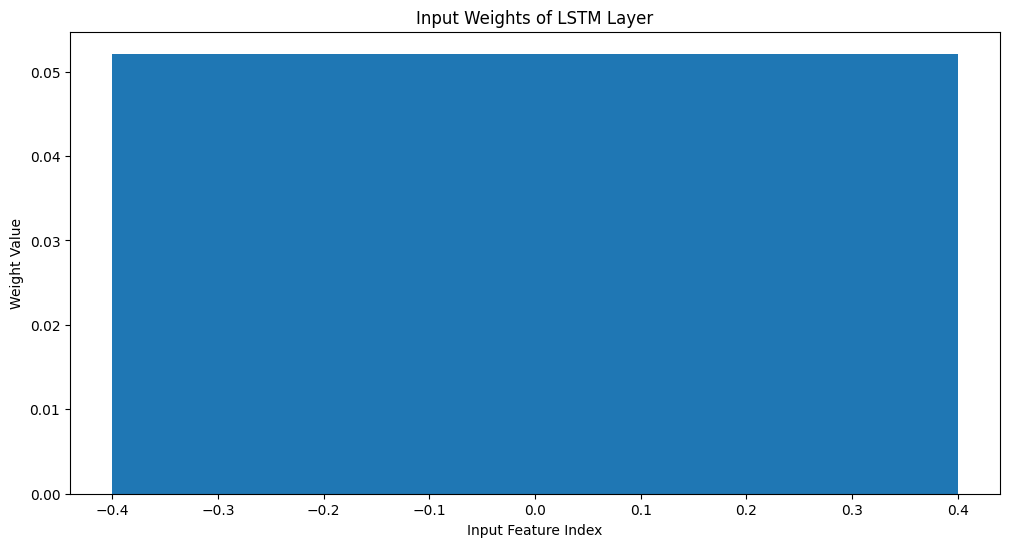

In [76]:
# Feature Importance (Input Weights)
weights = model.layers[0].get_weights()[0]
plt.figure(figsize=(12,6))
plt.bar(range(len(weights)), weights[:, 0])
plt.title('Input Weights of LSTM Layer')
plt.xlabel('Input Feature Index')
plt.ylabel('Weight Value')
plt.show()


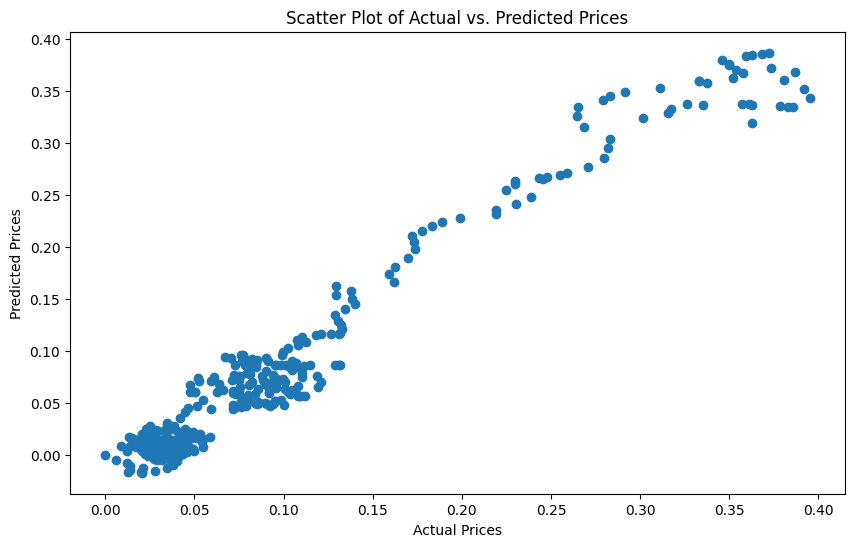

In [77]:
#Scatter Plot of Actual vs. Predicted Prices
plt.figure(figsize=(10,6))
plt.scatter(test['Close'], test['Predictions'])
plt.title('Scatter Plot of Actual vs. Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.show()

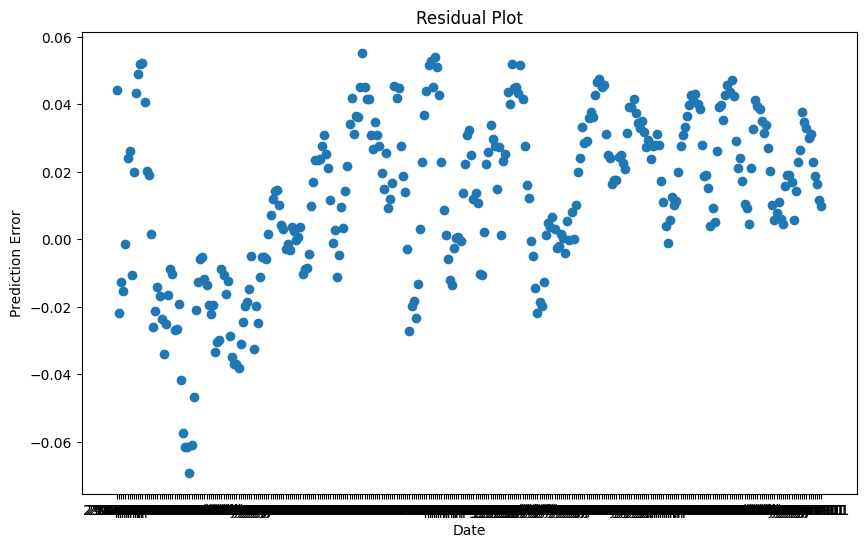

In [78]:
# Residual Plot
plt.figure(figsize=(10,6))
plt.scatter(test['Date'], error)
plt.title('Residual Plot')
plt.xlabel('Date')
plt.ylabel('Prediction Error')
plt.show()

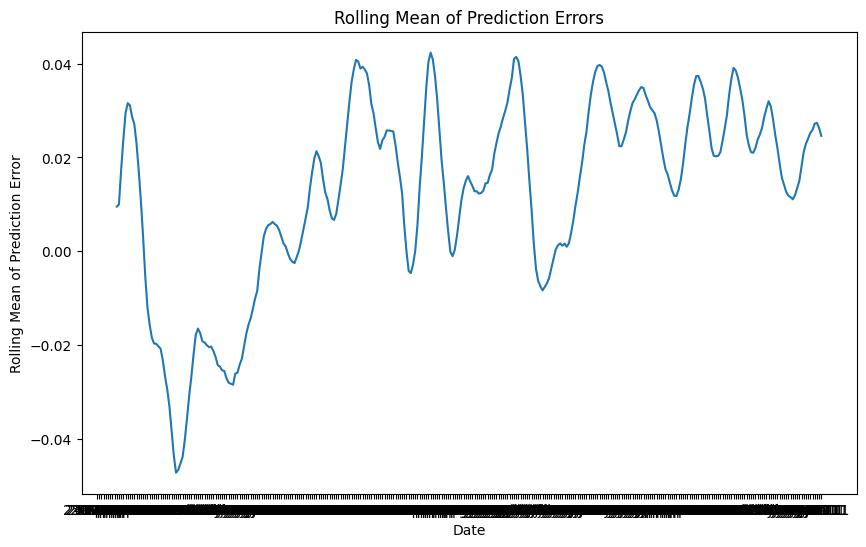

In [79]:
# Rolling Mean of Prediction Errors
rolling_mean = error.rolling(window=10).mean()
plt.figure(figsize=(10,6))
plt.plot(test['Date'], rolling_mean)
plt.title('Rolling Mean of Prediction Errors')
plt.xlabel('Date')
plt.ylabel('Rolling Mean of Prediction Error')
plt.show()